In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import inspect

currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
srcdir = parentdir + '/src'
os.sys.path.insert(1, srcdir)

import numpy as np

import time
import pybullet as p
import pybullet_data
import pinocchio as se3
import matplotlib
import tsid
import numpy.matlib as matlib
from numpy import nan
from numpy.linalg import norm as norm
import commands
import pandas as pd


import matplotlib.pyplot as plt
from pinbullet_wrapper import PinBulletWrapper
from pinocchio.robot_wrapper import RobotWrapper
from pinocchio.utils import zero

In [2]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

In [3]:
N_SIMULATION = 5000
SCENARIO = 'building'

data_path = parentdir + '/data/ns3/' + SCENARIO
path_received = data_path + '/raw/received_time.txt'
path_transmitted = data_path + '/raw/transmitted_time.txt'

serialNumber = []
TimeStampReceived = []
TimeStampTransmitted = []
TimeDiff = []

dataReceived = pd.read_csv(path_received, delimiter=":", header=None, names=["serial", "timeStamp"])
serialReceived   = dataReceived['serial'].values
sizee = dataReceived['serial'].size
timeStampReceived = dataReceived['timeStamp'].values

dataTransmitted = pd.read_csv(path_transmitted,delimiter=":", header=None, names=["serial", "timeStamp"])
serialTransmitted   = dataTransmitted['serial'].values
timeStampTransmitted = dataTransmitted['timeStamp'].values

outPutConcat = {}

for i in range(1, sizee):

    searchedResultA = dataReceived[dataReceived['serial'] == serialTransmitted[i]]
    #         print(searchedResultA['serial'].values[0])
    #         print(searchedResultA['timeStamp'].values[0])
    #         print(timeStampTransmitted[i])
    if (not searchedResultA.empty) and searchedResultA['timeStamp'].values[0] != 0 and timeStampTransmitted[i] != 0 :
        timediff = searchedResultA['timeStamp'].values[0] - timeStampTransmitted[i]
        serialNumber.append(searchedResultA['serial'].values[0])
        TimeStampReceived.append(searchedResultA['timeStamp'].values[0])
        TimeStampTransmitted.append(timeStampTransmitted[i])
    else:
        timediff = N_SIMULATION + 1
    TimeDiff.append(timediff)
    
rtt = 2e-3 * np.array(TimeDiff)
rtt = rtt[19000:]

In [4]:
N_SIMULATION = 5000
NUM_TRAJ = 10
for k in range(NUM_TRAJ):
    td = rtt[k * N_SIMULATION : (k + 1) * N_SIMULATION]
    time_received = np.array([i + td[i] for i in range(N_SIMULATION)])
    idx_most_recent_comm = 0
    delay = np.zeros(N_SIMULATION)
    DELAYED_IDX = []
    for i in range(N_SIMULATION):
        # find the latest command arrived before the current time
        idx_arrived = np.nonzero(time_received <= i)[0]
        if idx_arrived.size > 0:
            delayed_idx = idx_arrived.max()
            delay[i] = i - delayed_idx
        else:
            delayed_idx = 0
            delay[i] = i - delayed_idx
        DELAYED_IDX.append(delayed_idx)
    np.save(data_path + '/delayed_idx/'+ str(k), DELAYED_IDX)

(0, 200)

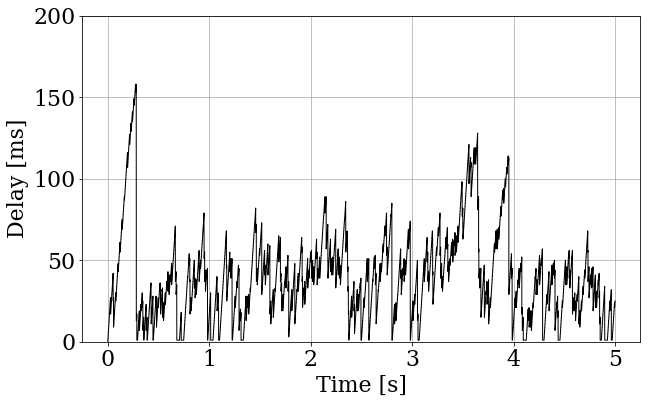

In [5]:
dt = 0.001
Time = np.arange(0, N_SIMULATION*dt, dt)
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(Time, delay, lw=1, c='k', ls='-', drawstyle='steps')

ax.grid()
ax.set_xlabel('Time [s]')
ax.set_ylabel('Delay [ms]' )
ax.ticklabel_format(style='sci',scilimits=(-3,4), axis='y')
ax.set_ylim([0, 200])